# Домашнее задание №1.2

Написать класс, реализующий алгоритм линейной регрессии from scratch, используя:
* градиентный спуск
* стохастический градиентный спуск

Дополнительное задание (получен файл creddebt.csv):
* разбить набор на обучающую и тестовую в соотношении 70/30
* провести стандартизацию признаков (для себя ответьте, зачем она нужна)
* создать новые признаки и проверить работу класса

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sb

from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

Зададим константы

In [2]:
# Шаг градиента
LR = 0.01
# Количество итераций
ITERATIONS_COUNT = 2000

#Размер батча (для SGD)
BATCH_SIZE = 100

# для random_state
SEED = 1234

Создание собственного класса для линейной регрессии

In [3]:
class MyLinearRegression():
    def __init__(self, learning_rate, iterations, batch_size) :
        self.learning_rate = learning_rate
        self.num_iters = iterations
        self.batch_size = batch_size

    # Градиентный спуск
    def fit_gd(self, X, Y) :
        # будем хранить ошибки на итерациях
        self.losses_gd = []
        # получаем размерность матрицы
        m, n = X.shape
        # инициализация начальных весов
        self.w_gd = np.zeros(n)
        self.w0_gd = 0

        for i in range(self.num_iters) :
            # Вычисляем предсказанные значения с текущими весами
            y_pred = self.predict(X, method='gd')
            # Добавляем текущую ошибку в список
            self.losses_gd.append(mean_squared_error(y_pred, Y))
            # Вычисляем градиенты
            dw = (1/m)*np.dot(X.T, (y_pred - Y))
            dw0 = (1/m)*np.sum((y_pred - Y))
            # обновляем веса в направлении антиградиента
            self.w_gd -= self.learning_rate*dw
            self.w0_gd -= self.learning_rate*dw0

        return self

    def fit_sgd(self, X, Y) :
        # будем хранить ошибки на итерациях
        self.losses_sgd = []
        # получаем размерность матрицы
        m, n = X.shape
        # инициализация начальных весов
        self.w_sgd = np.zeros(n)
        self.w0_sgd = 0
        n_batches = np.floor(len(Y)/self.batch_size)

        for i in range(self.num_iters) :
            # выбираем случайное значение из количества батчей, начиная с которого мы сможем взять batch нужного размера
            j = np.random.randint(n_batches)
            # вычисляем индекс, с которого будем брать батч
            indx = j*self.batch_size
            # берем батч
            xx = X[indx : indx+self.batch_size]
            yy = Y[indx : indx+self.batch_size]
            # Вычисляем предсказанные значения с текущими весами
            y_pred = self.predict(xx, method='sgd')
            # Добавляем текущую ошибку в список
            self.losses_sgd.append(mean_squared_error(y_pred, yy))
            # Вычисляем градиенты
            dw = (1/m)*np.dot(xx.T, (y_pred - yy))
            dw0 = (1/m)*np.sum((y_pred - yy))
            # обновляем веса в направлении антиградиента
            self.w_sgd -= self.learning_rate*dw
            self.w0_sgd -= self.learning_rate*dw0

        return self

    # Получение весовых коэффициентов с помощью обратной матрицы
    def fit_matrix(self, feat, targ):
        X = np.concatenate((np.ones((feat.shape[0], 1)), feat), axis=1)
        y = targ
        z = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        self.w_m = z[1:]
        self.w0_m = z[0]

    def fit(self, X, Y):
        self.fit_gd(X,Y)
        self.fit_sgd(X,Y)
        self.fit_matrix(X,Y)

    def predict(self, features, method):
        if method == 'gd':
            w = self.w_gd
            w0 = self.w0_gd
        elif method == 'sgd':
            w = self.w_sgd
            w0 = self.w0_sgd
        elif method == 'matrix':
            w = self.w_m
            w0 = self.w0_m
        return features.dot(w) + w0

Загрузка данных

In [4]:
df = pd.read_csv('creddebt.csv', sep=';', decimal=',')
display(df)

,age,ed,employ,address,income,debtinc,creddebt,othdebt
0,28,2,7,2,44,17.7,2.990592,4.797408
1,64,5,34,17,116,14.7,5.047392,12.004608
2,40,1,20,12,61,4.8,1.042368,1.885632
3,30,1,11,3,27,34.5,1.751220,7.563780
4,25,1,2,2,30,22.4,0.759360,5.960640
...,...,...,...,...,...,...,...,...
1495,34,3,8,4,83,11.0,1.853390,7.276610
1496,37,2,10,8,43,3.6,0.806508,0.741492
1497,25,5,0,3,16,3.2,0.288256,0.223744
1498,34,1,10,8,41,14.5,1.194945,4.750055


Значения признаков:
`age` - возраст
`ed` - тип образования
`employ` - стаж
`address` - срок проживания на последнем месте
`income` - доход
`debtinc` - отношение долга к доходу
`creddebt` - задолженность по кредитам
`othdebt` - другие долги

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1500 non-null   int64  
 1   ed        1500 non-null   int64  
 2   employ    1500 non-null   int64  
 3   address   1500 non-null   int64  
 4   income    1500 non-null   int64  
 5   debtinc   1500 non-null   float64
 6   creddebt  1500 non-null   float64
 7   othdebt   1500 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 93.9 KB


In [6]:
df.describe()

,age,ed,employ,address,income,debtinc,creddebt,othdebt
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,34.174000,2.639333,6.952000,6.305333,59.588667,9.929333,1.934922,3.844308
std,13.142306,1.144025,8.977644,6.047740,67.130160,6.671884,2.973989,5.333428
min,18.000000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,0.000000,2.000000,27.000000,4.800000,0.423225,1.106986
50%,31.000000,2.000000,4.000000,5.000000,40.000000,8.500000,0.986076,2.214072
75%,42.000000,4.000000,10.000000,9.000000,64.000000,13.525000,2.202150,4.573312
max,79.000000,5.000000,63.000000,34.000000,1079.000000,40.700000,35.972690,63.472640


Выделим целевой признак

In [7]:
features = df.drop('creddebt', axis=1)
target = df['creddebt']

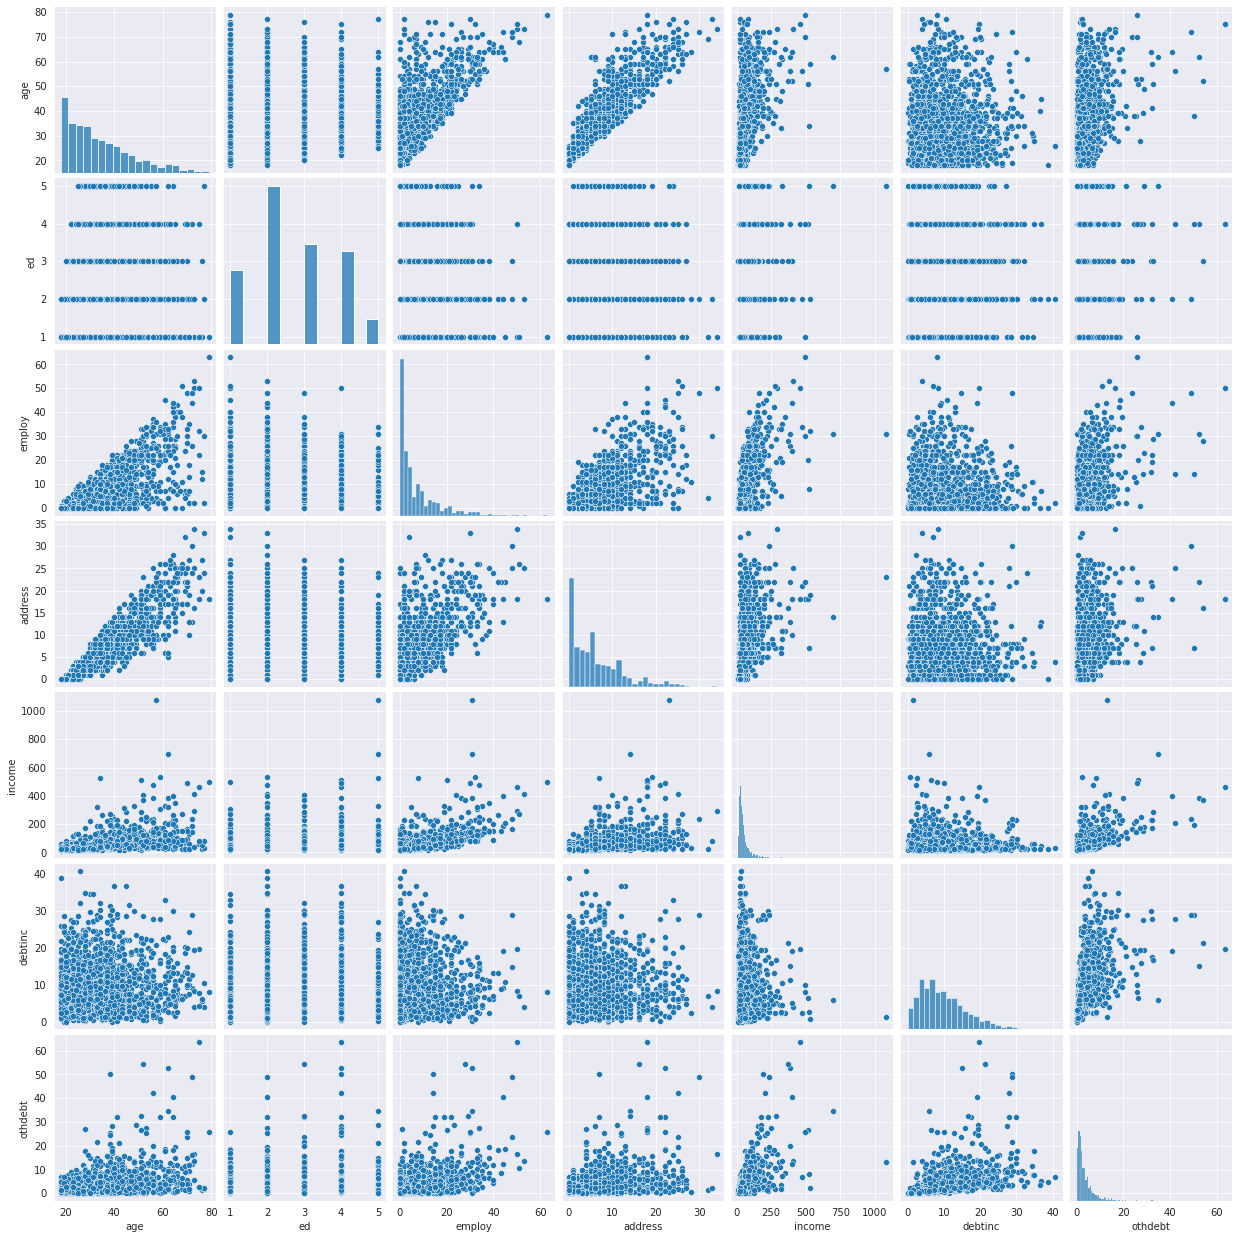

In [8]:
sb.pairplot(features)

Посмотрим корреляцию признаков

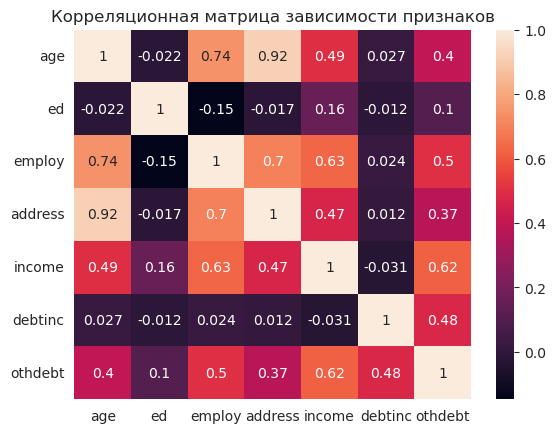

In [9]:
sb.heatmap(features.corr(), annot=True)
plt.title('Корреляционная матрица зависимости признаков')
plt.show()

Признаки `age` и `address` имеют сильную корреляционную связь. Пока не буду удалять один из признаков.

Посмотрим на вылеты

In [10]:
def plot_fliers(ds):
    red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
    fig, axs = plt.subplots(1, len(ds.columns), figsize=(12,6))
    for i, ax in enumerate(axs.flat):
        ax.boxplot(ds.iloc[:,i], flierprops=red_circle)
        ax.set_title(ds.columns[i], fontsize=10, fontweight='bold')
        ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout()

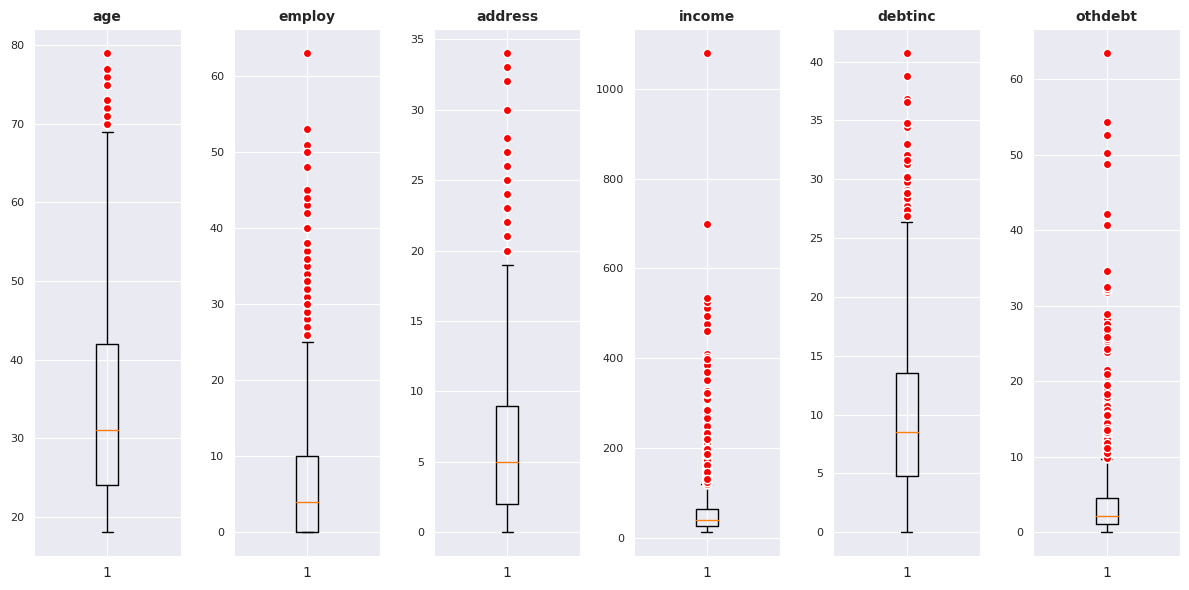

In [11]:
for_fliers = features.drop('ed', axis=1)
plot_fliers(for_fliers)

Удалим вылеты

In [12]:
def filter_fliers(data, columns):
    filter = data
    lh = {}

    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lh[col] = [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

    for key, value in lh.items():
        filter = filter[(filter[key]>value[0]) & (filter[key]<value[1])]

    return filter

In [13]:
df_filtered = filter_fliers(df, for_fliers)

In [14]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1244 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1244 non-null   int64  
 1   ed        1244 non-null   int64  
 2   employ    1244 non-null   int64  
 3   address   1244 non-null   int64  
 4   income    1244 non-null   int64  
 5   debtinc   1244 non-null   float64
 6   creddebt  1244 non-null   float64
 7   othdebt   1244 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 87.5 KB


In [15]:
print('Удалено вылетов:', len(df)-len(df_filtered))

Удалено вылетов: 256


Заменим зависимые и независимые признаки

In [16]:
features = df_filtered.drop('creddebt', axis=1)
target = df_filtered['creddebt']

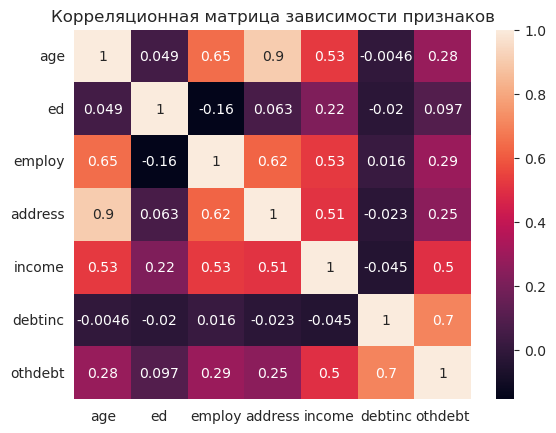

In [17]:
sb.heatmap(features.corr(), annot=True)
plt.title('Корреляционная матрица зависимости признаков')
plt.show()

Картина поменялась назначительно

В наборе данных имеется категориальный признак `ed` характеризующий тип образования клиента. Остальные признаки численные, к которым будет применяться стандартизация.
Получим список численных признаков и применим кодирование к категориальному.

In [18]:
numeric_columns = features.columns.tolist()
numeric_columns.remove('ed')

In [19]:
features = pd.get_dummies(features, drop_first=True, columns=['ed'])

In [20]:
display(features)

,age,employ,address,income,debtinc,othdebt,ed_2,ed_3,ed_4,ed_5
0,28,7,2,44,17.7,4.797408,1,0,0,0
2,40,20,12,61,4.8,1.885632,0,0,0,0
4,25,2,2,30,22.4,5.960640,0,0,0,0
5,35,2,9,38,10.9,2.679874,0,0,0,0
6,26,2,4,38,11.9,3.567858,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1495,34,8,4,83,11.0,7.276610,0,1,0,0
1496,37,10,8,43,3.6,0.741492,1,0,0,0
1497,25,0,3,16,3.2,0.223744,0,0,0,1
1498,34,10,8,41,14.5,4.750055,0,0,0,0


Разобьем на тренировочную и тестовую выборки в соотношении 70% на 30%. В качестве целевого признака выступает `creddebt`

In [21]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.3, random_state=SEED)

Стандартизируем данные

In [22]:
scaler = StandardScaler()
scaler.fit(x_train[numeric_columns])

x_train[numeric_columns] = scaler.transform(x_train[numeric_columns])
x_test[numeric_columns] = scaler.transform(x_test[numeric_columns])

In [23]:
display(x_train)

,age,employ,address,income,debtinc,othdebt,ed_2,ed_3,ed_4,ed_5
1311,-0.998721,-0.833136,-0.888962,-0.130710,1.639667,-0.232879,0,1,0,0
396,-0.000115,-0.833136,0.481499,-0.036378,-0.942904,-1.015042,0,0,1,0
722,1.897237,3.405627,1.395141,2.935097,-0.767219,0.795184,0,0,1,0
1205,1.298074,0.272628,1.623551,-0.130710,-0.046910,-0.411697,0,1,0,0
1395,-1.098582,-0.833136,-1.117373,-1.357033,-1.610508,-1.237425,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
815,-0.199836,0.641216,0.024679,-0.130710,0.427440,-0.603016,0,1,0,0
1483,-1.298303,-0.833136,-1.117373,-0.743872,-0.328006,-0.608146,1,0,0,0
1309,0.499188,-0.095960,0.481499,-0.366542,1.341003,1.042577,1,0,0,0
886,2.296680,-0.464548,3.222423,-0.319375,-0.486123,-0.582261,0,1,0,0


In [24]:
lr = MyLinearRegression(learning_rate=LR, iterations=ITERATIONS_COUNT, batch_size=BATCH_SIZE)
lr.fit(x_train, y_train)

Итерационное снижение ошибок

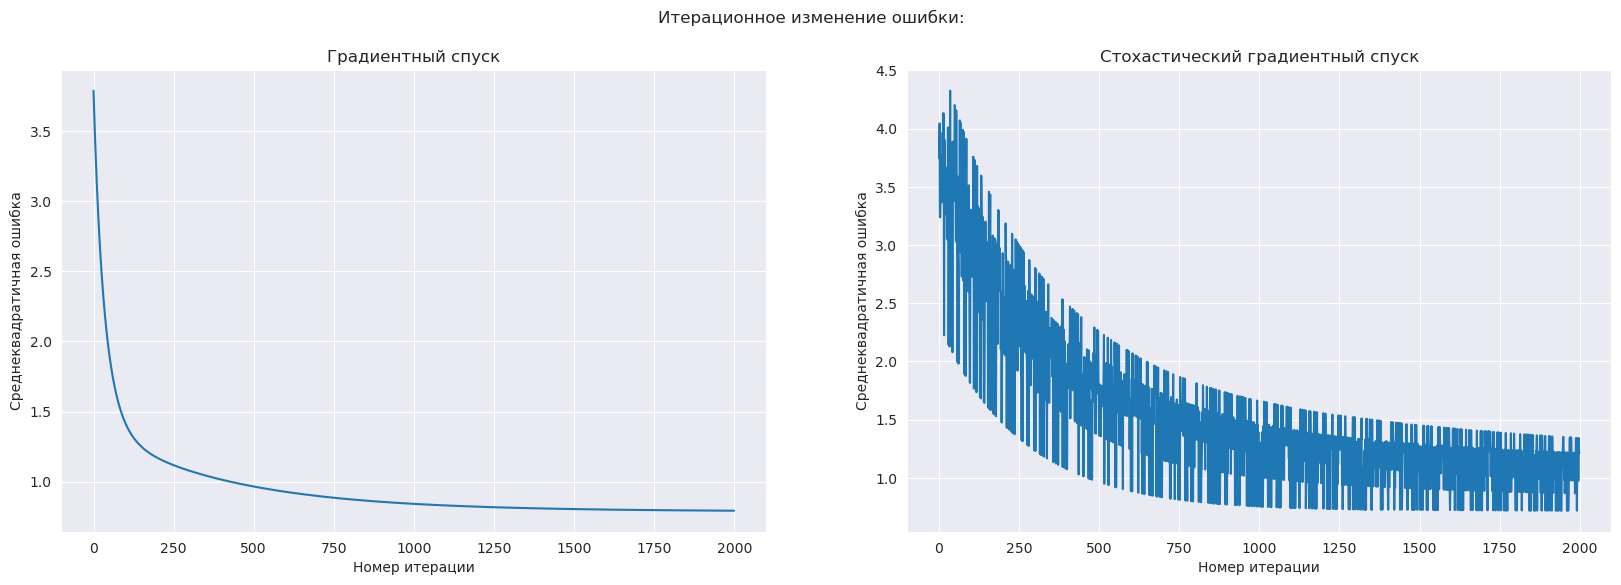

In [25]:
plt.figure(figsize=[20, 6])
plt.suptitle('Итерационное изменение ошибки:')
plt.subplot(1, 2, 1)
plt.plot(lr.losses_gd)
plt.title('Градиентный спуск')
plt.xlabel('Номер итерации')
plt.ylabel('Среднеквадратичная ошибка')
plt.subplot(1, 2, 2)
plt.plot(lr.losses_sgd)
plt.title('Стохастический градиентный спуск')
plt.xlabel('Номер итерации')
plt.ylabel('Среднеквадратичная ошибка')
plt.show()

Получение предсказаний и расчет метрик

In [26]:
def print_results(model, x, y):
    predict_gd = model.predict(x, method='gd')
    predict_sgd = model.predict(x, method='sgd')
    predict_m = model.predict(x, method='matrix')

    r2_gd = r2_score(y, predict_gd)
    rmse_gd = mean_squared_error(predict_gd, y) ** 0.5

    r2_sgd = r2_score(y, predict_sgd)
    rmse_sgd = mean_squared_error(predict_sgd, y) ** 0.5

    r2_m = r2_score(y, predict_m)
    rmse_m = mean_squared_error(predict_m, y) ** 0.5

    display(pd.DataFrame([[r2_gd, rmse_gd],
                          [r2_sgd, rmse_sgd],
                          [r2_m, rmse_m]
                          ],
                         index=['GD', 'SGD', 'Matrix'], columns=['R2', 'RMSE'])
            .style.format(precision=4).set_properties(**{'width': '75px', 'text-align': 'right'}))

Проверка с реализацией sklearn

In [27]:
model_sk = LinearRegression()
model_sk.fit(x_train, y_train)
predict_train_sk = model_sk.predict(x_train)
predict_test_sk = model_sk.predict(x_test)

r2_train_sk = r2_score(y_train, predict_train_sk)
rmse_train_sk = mean_squared_error(predict_train_sk, y_train) ** 0.5

r2_test_sk = r2_score(y_test, predict_test_sk)
rmse_test_sk = mean_squared_error(predict_test_sk, y_test) ** 0.5

Вывод результатов

In [28]:
print('Шаг градиента:', LR)
print('Количество итераций:', ITERATIONS_COUNT)
print('Размер батча для SGD:', BATCH_SIZE)

print('\nИтоговые метрики на тренировочной выборке:')
print_results(lr, x_train, y_train)

print('\nИтоговые метрики на тестовой выборке:')
print_results(lr, x_test, y_test)

print('\nМетрики реализации, встроенной в sklearn:')
display(pd.DataFrame([[r2_train_sk, rmse_train_sk],
                      [r2_test_sk, rmse_test_sk]
                      ],
                     index=['Тренировочная', 'Тестовая'], columns=['R2', 'RMSE'])
        .style.format(precision=4).set_properties(**{'width': '75px', 'text-align': 'right'}))

Шаг градиента: 0.01
Количество итераций: 2000
Размер батча для SGD: 100

Итоговые метрики на тренировочной выборке:


,R2,RMSE
GD,0.6257,0.8906
SGD,0.4556,1.0741
Matrix,0.6297,0.8857



Итоговые метрики на тестовой выборке:


,R2,RMSE
GD,0.5880,0.9771
SGD,0.4892,1.0879
Matrix,0.5859,0.9795



Метрики реализации, встроенной в sklearn:


,R2,RMSE
Тренировочная,0.6297,0.8857
Тестовая,0.5859,0.9795
